In [31]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

In [32]:
inputPath = "models/SNet_count_aggregation.gml"
SNet = nx.Graph(nx.read_gml(inputPath))

inputPath = "models/SNetT_count_aggregation.gml"
SNetT = nx.Graph(nx.read_gml(inputPath))

inputPath = "models/SNet_count_aggregation_clean.gml"
SNetClean = nx.Graph(nx.read_gml(inputPath))

In [33]:
#maxCC = max(nx.connected_components(SNet), key=len)
#S = [SNet.subgraph(c).copy() for c in nx.connected_components(SNet)]
#DomComSNet = SNet.subgraph(maxCC).copy()

#comp = nx.community.girvan_newman(DomComSNet)
#k = 5

#hierarchicalDecomposition = {}

#i = 2

#for communities in itertools.islice(comp, k):
#    hierarchicalDecomposition[i] = tuple(sorted(c) for c in communities)
    
#    i = i + 1

In [34]:
maxCC = max(nx.connected_components(SNetT), key=len)
S = [SNetT.subgraph(c).copy() for c in nx.connected_components(SNetT)]
DomComSNetT = SNetT.subgraph(maxCC).copy()

comp = nx.community.girvan_newman(DomComSNetT)
k = 5

hierarchicalDecomposition = {}

i = 2

for communities in itertools.islice(comp, k):
    hierarchicalDecomposition[i] = tuple(sorted(c) for c in communities)
    
    i = i + 1

In [35]:
maxCC = max(nx.connected_components(SNetClean), key=len)
S = [SNetClean.subgraph(c).copy() for c in nx.connected_components(SNetClean)]
DomComSNetClean = SNetClean.subgraph(maxCC).copy()

comp = nx.community.girvan_newman(DomComSNetClean)
k = 5

hierarchicalDecomposition = {}

i = 2

for communities in itertools.islice(comp, k):
    hierarchicalDecomposition[i] = tuple(sorted(c) for c in communities)
    
    i = i + 1

In [36]:
# Dendrogram
# https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm

def plot_and_save_dendrogram(G):

    plt.rcParams["figure.figsize"] = (24,13)
    # get Girvan-Newman communities list
    communities = list(nx.community.girvan_newman(G))

    # building initial dict of node_id to each possible subset:
    node_id = 0
    init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
    for comm in communities:
        for subset in list(comm):
            if subset not in init_node2community_dict.values():
                node_id += 1
                init_node2community_dict[node_id] = subset

    # turning this dictionary to the desired format in @mdml's answer
    node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
    for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
        for node_id_parent, group in init_node2community_dict.items():
            if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
                node_id_to_children[node_id_parent].append(node_id1)
                node_id_to_children[node_id_parent].append(node_id2)

    # also recording node_labels dict for the correct label for dendrogram leaves
    node_labels = dict()
    for node_id, group in init_node2community_dict.items():
        if len(group) == 1:
            node_labels[node_id] = list(group)[0]
        else:
            node_labels[node_id] = ''

    # also needing a subset to rank dict to later know within all k-length merges which came first
    subset_rank_dict = dict()
    rank = 0
    for e in communities[::-1]:
        for p in list(e):
            if tuple(p) not in subset_rank_dict:
                subset_rank_dict[tuple(sorted(p))] = rank
                rank += 1
    subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

    # my function to get a merge height so that it is unique (probably not that efficient)
    def get_merge_height(sub):
        sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
        n = len(sub_tuple)
        other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
        min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
        range = (max_rank-min_rank) if max_rank > min_rank else 1
        return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

    # finally using @mdml's magic, slightly modified:
    G           = nx.DiGraph(node_id_to_children)
    nodes       = G.nodes()
    leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
    inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

    # Compute the size of each subtree
    subtree = dict( (n, [n]) for n in leaves )
    for u in inner_nodes:
        children = set()
        node_list = list(node_id_to_children[u])
        while len(node_list) > 0:
            v = node_list.pop(0)
            children.add( v )
            node_list += node_id_to_children[v]
        subtree[u] = sorted(children & leaves)

    inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

    # Construct the linkage matrix
    leaves = sorted(leaves)
    index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
    Z = []
    k = len(leaves)
    for i, n in enumerate(inner_nodes):
        children = node_id_to_children[n]
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
            Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
            index[z] = k
            subtree[z] = list(z)
            x = z
            k += 1

    # dendrogram
    plt.figure()
    dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
    plt.savefig('dendrogram.png')

In [37]:
#plot_and_save_dendrogram(DomComSNet)

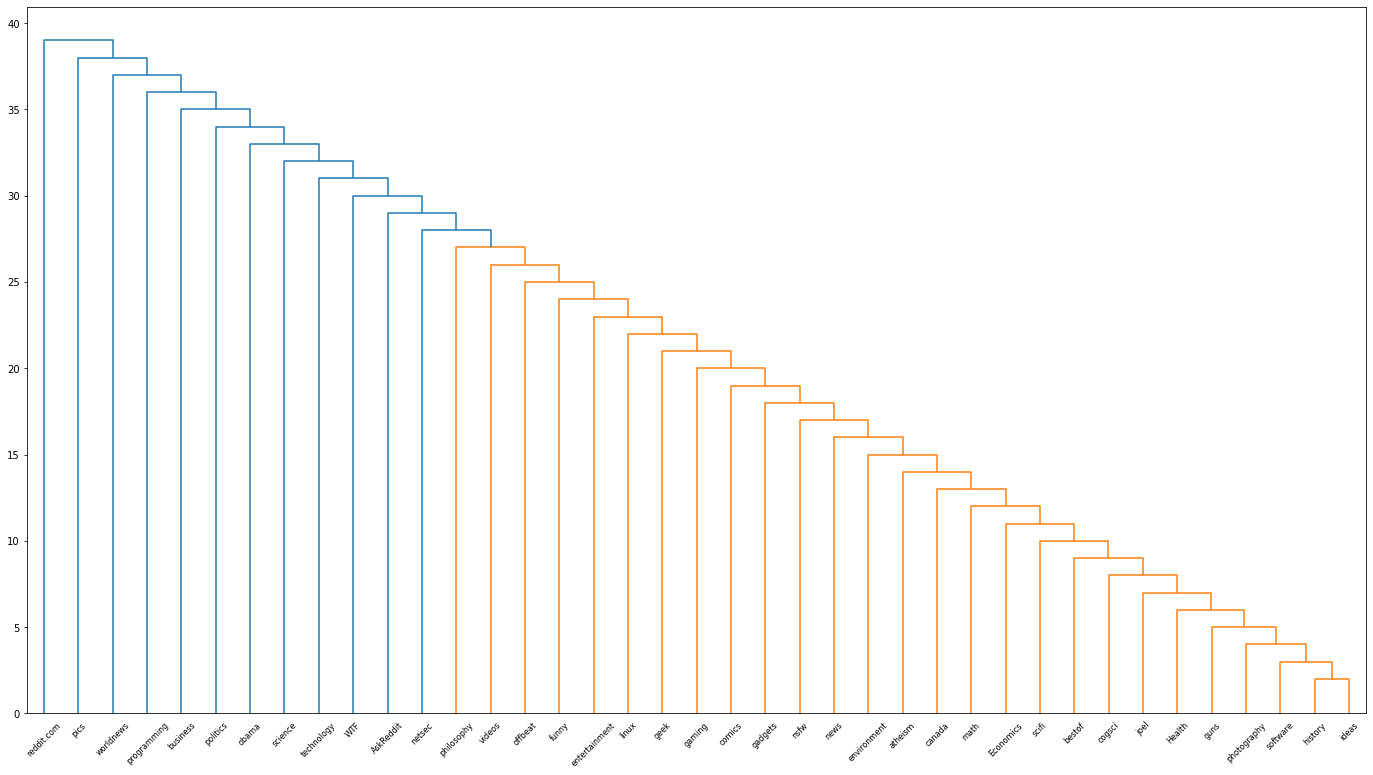

In [38]:
plot_and_save_dendrogram(DomComSNetT)

In [39]:
plot_and_save_dendrogram(DomComSNetClean)

KeyboardInterrupt: 